In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

ModuleNotFoundError: No module named 'seaborn'

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
from skimage.io import imread as imread
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
from skimage.color import label2rgb
image_dir = Path('..') / 'input' / 'minigredients'
mapping_file = Path('..') / 'input' / 'ingredients-to-allergies-mapping' / 'clean_list.json'
alleg_df = pd.read_json(mapping_file)
alleg_df['image_path'] = alleg_df['image_path'].map(lambda x: image_dir / 'subset' / x) 
print(alleg_df['image_path'].map(lambda x: x.exists()).value_counts())
allergens = alleg_df.columns[3:].tolist()
alleg_df.sample(2)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

True    9653
Name: image_path, dtype: int64


,image_path,title,ingredients_list,cows milk,eggs,tree nuts,peanuts,shellfish,wheat,soy,fish
5252,../input/minigredients/subset/8b392cd876.jpg,Lemony Bean Duo,"[1/2 c. packed fresh mint leaves, 1 1/2 lb. gr...",0,0,0,0,0,0,0,0
6055,../input/minigredients/subset/a07b6bcd3b.jpg,D'Arabian's Roasted Garlic Clove Chicken Thighs,"[8 chicken thighs, kosher salt, fresh ground b...",1,0,0,0,0,2,0,0


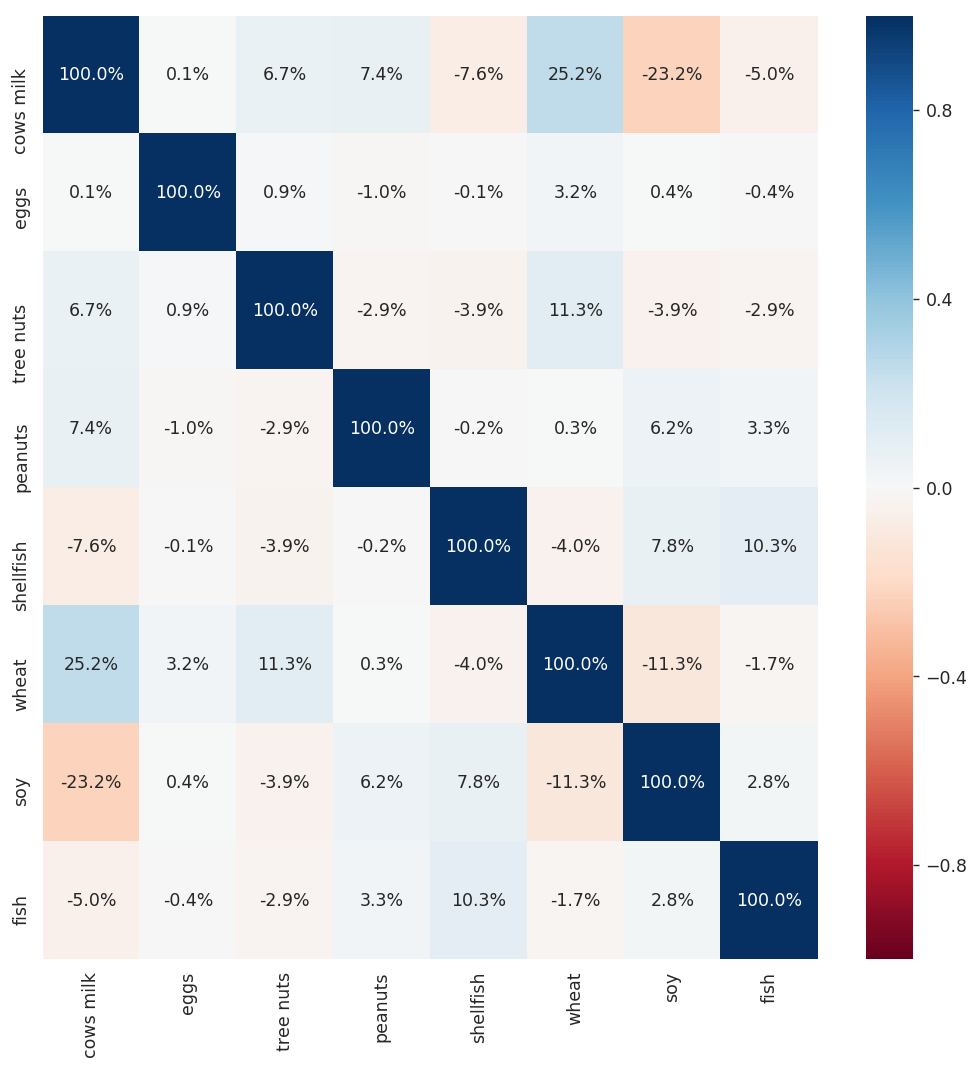

In [4]:
co_all = np.corrcoef(np.stack(alleg_df[allergens].applymap(lambda x: 1 if x>0 else 0).values, 0).T)
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(co_all, annot=True, fmt='2.1%', ax=ax1, cmap='RdBu', vmin=-1, vmax=1)
ax1.set_xticklabels(allergens, rotation=90)
ax1.set_yticklabels(allergens);

In [8]:
alleg_df['aller_vec'] = alleg_df[allergens].applymap(lambda x: 1 if x>0 else 0).values.tolist()
alleg_df.sample(2)

,image_path,title,ingredients_list,cows milk,eggs,tree nuts,peanuts,shellfish,wheat,soy,fish,aller_vec
5456,../input/minigredients/subset/8fdbcf0419.jpg,Eggnog Rum Bundt Cake,"[3 cups unsifted flour, 1 teaspoon baking powd...",2,0,0,0,0,1,0,0,"[1, 0, 0, 0, 0, 1, 0, 0]"
7048,../input/minigredients/subset/bae18ec7ce.jpg,detox water! !,"[1 bunch mint, 1 cucumber sliced, 3 lemons sli...",0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0]"


In [10]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(alleg_df.drop('ingredients_list', 1), 
                 test_size = 0.3, 
                  # hack to make stratification work                  
                 stratify = alleg_df['aller_vec'].map(lambda x: x[0:3]))
print(raw_train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

6757 training masks
2896 validation masks


In [ ]:
GAUSSIAN_NOISE = 0.05
# number of validation images to use
VALID_IMG_COUNT = 1500
BASE_MODEL='InceptionV3' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (299, 299) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 64 # [1, 8, 16, 24]
DROPOUT = 0.5
DENSE_COUNT = 256
SAMPLE_PER_GROUP = 1500
LEARN_RATE = 3e-4
EPOCHS = 30
RGB_FLIP = 1 # should rgb be flipped when rendering images

In [ ]:
train_df = pd.concat([raw_train_df.\
     groupby(raw_train_df[k].map(lambda x: x>0)).\
     apply(lambda x: x.sample(SAMPLE_PER_GROUP//2, replace=True)).\
     reset_index(drop=True) 
     for k in allergens])
train_df.shape[0]

# Prepare for Model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.7, 1.3],
                  horizontal_flip = True, 
                  vertical_flip = False,
                  fill_mode = 'reflect',
                   data_format = 'channels_last',
              preprocessing_function = preprocess_input)

valid_args = dict(fill_mode = 'reflect',
                   data_format = 'channels_last',
                  preprocessing_function = preprocess_input)

core_idg = ImageDataGenerator(**dg_args)
valid_idg = ImageDataGenerator(**valid_args)

In [ ]:
def flow_from_dataframe(img_data_gen, raw_df, path_col, y_col, **dflow_args):
    """Keras update makes this much easier"""
    in_df = raw_df.copy()
    in_df[path_col] = in_df[path_col].map(str)
    in_df[y_col] = in_df[y_col].map(lambda x: np.array(x))
    df_gen = img_data_gen.flow_from_dataframe(in_df, 
                                              x_col=path_col,
                                              y_col=y_col,
                                    class_mode = 'raw',
                                    **dflow_args)
    # posthoc correction
    df_gen._targets = np.stack(df_gen.labels, 0)
    return df_gen

In [ ]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'image_path',
                            y_col = 'aller_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

# used a fixed dataset for evaluating the algorithm
valid_x, valid_y = next(flow_from_dataframe(valid_idg, 
                               valid_df, 
                             path_col = 'image_path',
                            y_col = 'aller_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = VALID_IMG_COUNT)) # one big batch
print(valid_x.shape, valid_y.shape)

In [ ]:
t_x, t_y = next(train_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1) = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(montage_rgb((t_x-t_x.min())/(t_x.max()-t_x.min()))[:, :, ::RGB_FLIP])
ax1.set_title('images')

### Show the labels
Here we show the labels for the batch items and can see how frequent each one is

In [ ]:
plt.matshow(t_y.T)

# Build a Model

In [ ]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

In [ ]:
from keras import models, layers
from keras.optimizers import Adam
img_in = layers.Input(t_x.shape[1:], name='Image_RGB_In')
img_noise = layers.GaussianNoise(GAUSSIAN_NOISE)(img_in)
pt_features = base_pretrained_model(img_noise)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
bn_features = layers.BatchNormalization()(pt_features)
feature_dropout = layers.SpatialDropout2D(DROPOUT)(bn_features)
gmp_dr = layers.GlobalAvgPool2D()(bn_features)
dr_steps = layers.Dropout(DROPOUT)(layers.Dense(DENSE_COUNT, activation = 'relu')(gmp_dr))
out_layer = layers.Dense(t_y.shape[1], activation = 'sigmoid')(dr_steps)

allergen_model = models.Model(inputs = [img_in], outputs = [out_layer], name = 'full_model')

allergen_model.compile(optimizer = Adam(lr=LEARN_RATE), 
                   loss = 'binary_crossentropy',
                   metrics = ['binary_accuracy', 'mae'])

allergen_model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('allergen_detector')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
from IPython.display import clear_output
train_gen.batch_size = BATCH_SIZE
fit_results = allergen_model.fit_generator(train_gen, 
                            steps_per_epoch = train_gen.samples//BATCH_SIZE,
                      validation_data = (valid_x, valid_y), 
                      epochs = EPOCHS, 
                      callbacks = callbacks_list,
                      workers = 3)
clear_output()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.plot(fit_results.history['loss'], label='Training')
ax1.plot(fit_results.history['val_loss'], label='Validation')
ax1.legend()
ax1.set_title('Loss')
ax2.plot(fit_results.history['binary_accuracy'], label='Training')
ax2.plot(fit_results.history['val_binary_accuracy'], label='Validation')
ax2.legend()
ax2.set_title('Binary Accuracy')
ax2.set_ylim(0, 1)

In [ ]:
allergen_model.load_weights(weight_path)
allergen_model.save('full_allergen_model.h5')

In [ ]:
for k, v in zip(allergen_model.metrics_names, 
        allergen_model.evaluate(valid_x, valid_y)):
    if k!='loss':
        print('{:40s}:\t{:2.1f}%'.format(k, 100*v))

In [ ]:
t_x, t_y = next(train_gen)
t_yp = allergen_model.predict(t_x)
fig, (m_axs) = plt.subplots(4, 4, figsize = (20, 20))
for i, c_ax in enumerate(m_axs.flatten()):
    c_ax.imshow(((t_x[i]-t_x.min())/(t_x.max()-t_x.min()))[:, ::RGB_FLIP])
    c_title = '\n'.join(['{}: Pred: {:2.1f}%'.format(allergens[j], 100*t_yp[i, j]) 
                         for j, v in enumerate(t_y[i]) if v>0.5])
    c_ax.set_title(c_title)
    c_ax.axis('off')

# Validation Data Results
Here we show the results on validation data

In [ ]:
t_x, t_y = valid_x, valid_y
t_yp = allergen_model.predict(t_x)
fig, (m_axs) = plt.subplots(8, 2, figsize = (10, 20))
for i, (c_ax, d_ax) in enumerate(m_axs):
    c_ax.imshow(((t_x[i]-t_x.min())/(t_x.max()-t_x.min()))[:, ::RGB_FLIP])
    c_ax.axis('off')
    d_ax.barh(np.arange(len(allergens))+0.1, t_yp[i], alpha=0.5, label='Predicted')
    d_ax.barh(np.arange(len(allergens))-0.1, t_y[i]+0.001, alpha=0.5, label='Ground Truth')
    d_ax.set_yticks(range(len(allergens)))
    d_ax.set_yticklabels(allergens, rotation=0)
    d_ax.legend();

## Detailed Performance by group

In [ ]:
pred_df = pd.concat([
    pd.DataFrame(t_yp, columns=allergens).assign(source='Prediction').assign(id=range(t_yp.shape[0])),
    pd.DataFrame(t_y, columns=allergens).assign(source='Ground-truth').assign(id=range(t_yp.shape[0]))
])
flat_pred_df = pd.melt(pred_df, id_vars=['source', 'id']).pivot_table(index=['id', 'variable'], columns='source', values='value').reset_index()
flat_pred_df['Ground-truth'] = flat_pred_df['Ground-truth'].map(lambda x: 'Positive' if x>0.5 else 'Negative')
sns.catplot(data=flat_pred_df, x='Ground-truth', y='Prediction', col='variable', kind='swarm',  col_wrap=4)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
sns.swarmplot(data=flat_pred_df, hue='Ground-truth', y='Prediction', x='variable', size=2.0, ax=ax1)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
sns.boxplot(data=flat_pred_df, hue='Ground-truth', y='Prediction', x='variable', ax=ax1)

## Class-level ROC curves

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
for i, c_all in enumerate(allergens):
    tpr, fpr, thresh = roc_curve(y_true=t_y[:, i], y_score=t_yp[:, i])
    auc_roc = roc_auc_score(y_true=t_y[:, i], y_score=t_yp[:, i])
    ax1.plot(tpr, fpr, '.-', label='{} (AUC:{:2.1%})'.format(c_all, auc_roc), lw=2)
ax1.legend()

In [1]:
allergen_model.get_input_at(0), allergen_model.get_output_at(0)

NameError: name 'allergen_model' is not defined

In [ ]:
# install tensorflowjs
!pip install -qq tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format keras \
                       full_allergen_model.h5 \
                       .

In [ ]:
!ls -lh

In [ ]:
from IPython.display import FileLink
!tar -czf workspace.tar.gz *

In [ ]:
FileLink('workspace.tar.gz')